## Refining Insights Using LLM

In [65]:
import os 
from openai import OpenAI
import pickle
from dotenv import dotenv_values
import pandas as pd
import tiktoken
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from plotly.offline import plot
from IPython.display import display, HTML

config = dotenv_values("../.env")

DATA_ROOT = "../data/repro_mri_scoping"

client = OpenAI(api_key=config['OPENAI_KEY'])

def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

def write_file(file_path, content):
    with open(file_path, 'w') as file:
        file.write(content)

def write_pickle(filename,content):
    with open(filename, 'wb') as file:
        pickle.dump(content, file)

def read_pickle(file_name):
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    return data

def get_output_dir(file_name):
    op_dir = "../output"
    if not os.path.exists(op_dir):
        os.mkdir(op_dir)
    return os.path.join(op_dir,file_name)

def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input = [text], model=model).data[0].embedding

## Start a chat session with GPT


In [48]:
directory_path = os.path.join(DATA_ROOT,"repro_insights_parsed_nov23")

# Read the data that has been crawled and parsed.
input_files = [os.path.join(directory_path,f) for f in os.listdir(directory_path) if f.endswith('.txt')]

# Task definition for GPT
messages = [{"role": "system", "content": "You are a helpful assistant designed to understand and summarize the reproducibility aspects of neuroimaging research articles."}]

"""
!!!! WARNING !!!!

The following code requires GPT tokens to 
feed insight files one by one and to return 
a summary. Estimated cost ~6-8 USD.
"""

if config['OPENAI_KEY']:
    # Comment out this line to run it on all the entries.
    input_files = input_files[0:2]
    
    for ii, cur_file in enumerate(input_files):
        cur_content = read_file(cur_file)
        print(f"Requesting summary for {cur_file}")
        messages.append({"role": "user", "content": f"The following content is from ARTICLE {ii+1}. In relavance to its title and abstract, create 4 keywords, then summarize what did the study achieve and why it was reproducible in 4 sentences: {cur_content}"})
        response = client.chat.completions.create(
          model="gpt-4-1106-preview",
          messages= messages
        )
        try:
            cur_response = {"role": "assistant", "content": response.choices[0].message.content}
            messages.append(cur_response)
            write_pickle(get_output_dir("gpt_chat.pkl"),messages)
        except Exception as e:        
            print(f"Exception: {e}")
            write_pickle(get_output_dir("gpt_chat.pkl"),messages)
    gpt_outputs = os.path.join(get_output_dir("gpt_chat.pkl"))            
else: 
    print('API key not found. Available dataset will be used. Example: \n')
    gpt_outputs = os.path.join(DATA_ROOT, "gpt_chat.pkl")
    messages = read_pickle(gpt_outputs)
    print(messages[0:3])

API key not found. Available dataset will be used. Example: 

[{'role': 'system', 'content': 'You are a helpful assistant designed to understand and summarize the reproducibility aspects of neuroimaging research articles.'}, {'role': 'user', 'content': 'The following content is from ARTICLE 1. In relavance to its title and abstract, create 4 keywords, then summarize what did the study achieve and why it was reproducible in 4 sentences: Title: In vivo magnetic resonance 31P‐Spectral Analysis With Neural Networks: 31P‐SPAWNN \nAbstract: We have introduced an artificial intelligence framework, 31P‐SPAWNN, in order to fully analyze phosphorus‐31 ( 31$$ {}^{31} $$ P) magnetic resonance spectra. The flexibility and speed of the technique rival traditional least‐square fitting methods, with the performance of the two approaches, are compared in this work. \nReproducibility Insights:\nGeneral questions\nQuestions about the specific reproducible research habit\n\nThis MRM Reproducible Research 

## Create a high-level review of all the summarized content

In [45]:
# List of dictionaries
if config['OPENAI_KEY']:
    # THIS ASSUMES THAT THE OUTPUT WAS MADE AVAILABLE IN THE PREVIOUS CELL    
    messages.append({"role": "user", "content": f"Generate a comprehensive scoping review on the reproducibility of neuroimaging, incorporating insights from the 31 articles you summarized in our previous conversation. Provide examples and key findings to offer a thorough examination of the current state of reproducibility in neuroimaging research."})
    
    response = client.chat.completions.create(
       model="gpt-4-1106-preview",
       messages= messages)
    
    cur_response = {"role": "assistant", "content": response.choices[0].message.content}
    messages.append(cur_response)
    
    article = messages[-1]['content']
    
    with open(get_output_dir('review_article_summary.txt'), 'w') as file:
        file.write(article)
    
    print(messages[-1]['content'])
else:
    # Simply print the output
    print('API key not found. An example output will be displayed from the previous results. \n')
    gpt_txt = read_file(os.path.join(DATA_ROOT, "review1.txt"))
    print(gpt_txt)

API key not found. Available output will be displayed. 

**Scoping Review: Reproducibility in Neuroimaging Research**

**Introduction**
Reproducibility remains a cornerstone of scientific inquiry, its importance amplified in the complex and rapidly evolving field of neuroimaging. Studies leveraging magnetic resonance imaging (MRI), magnetic resonance spectroscopy (MRS), and other neuroimaging modalities are inherently data-intensive and computationally demanding. Ensuring reproducibility thus poses a unique set of challenges and necessitates the diligent application of methods that foster transparency, verification, and extension of research findings. This scoping review examines the current landscape of reproducible research practices in neuroimaging across various studies, drawing attention to common strategies, tools, and repositories used to achieve reproducible outcomes.

**Methods and Techniques for Ensuring Reproducibility**
Reproducibility in neuroimaging research is predicated

## Save GPT-generated summaries with matching paper IDs

In [56]:
if config['OPENAI_KEY']:

    # messages variable should be in scope. Please see previous cells.
    # Fetch this from the saved data
    input_files = [os.path.join(DATA_ROOT, "gpt_insights_parsed_nov23", f) for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    if not os.path.exists(get_output_dir("summary")):
        os.mkdir(get_output_dir("summary"))
    
    summary_files = [os.path.join(get_output_dir("summary"), f) for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    large_summary = ''
    it = 0
    for msg in messages:
        if msg['role'] == "assistant":
            large_summary += "\n" + msg['content'] + "\n ---------------------------- \n"
            write_file(summary_files[it],msg['content'])
            it = it +1 
    
    write_file(get_output_dir('gpt_combined_summaries.txt'),large_summary)
else:
    print('API key not found. 3 example outputs will be displayed. \n')
    gpt_outputs = os.path.join(DATA_ROOT, "gpt_chat.pkl")
    messages = read_pickle(gpt_outputs)
    it = 0
    for msg in messages:
        if msg['role'] == "assistant":
           print(msg['content'] + '\n')
           it+=1
        if it == 3:
            break
    

## Embeddings

In [62]:
if config['OPENAI_KEY']:
    # Output path will be checked for the summaries 
    summary_files = [os.path.join(get_output_dir("summary", f)) for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    # List to store summaries
    summaries = []
    
    # Iterate through each txt file in the directory
    for filename in summary_files:
        content = read_file(filename)
        summaries.append(content)
    
    # Create a Pandas DataFrame with a column named 'summary'
    df = pd.DataFrame({'summary': summaries})
    
    embedding_model = "text-embedding-ada-002"
    embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
    max_tokens = 8000
    top_n = 1000
    
    encoding = tiktoken.get_encoding(embedding_encoding)
    
    # omit reviews that are too long to embed
    df["n_tokens"] = df.summary.apply(lambda x: len(encoding.encode(x)))
    df = df[df.n_tokens <= max_tokens].tail(top_n)

    # Call GPT for embedding
    df["embedding"] = df.summary.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
    df.to_csv(get_output_dir('gpt_summary_embedding.csv'), index=False)
else:
    # Read embedding data that has been saved
    df = pd.read_csv(os.path.join(DATA_ROOT,'gpt_summary_embedding_nov23.csv'))
    print(df.head())

                                             summary  n_tokens  \
0  Keywords: 31P‐SPAWNN, neural networks, reprodu...       201   
1  Keywords: Cystic Fibrosis, Hyperpolarized 129X...       203   
2  Keywords: Dynamic MRI, Non-gated Acquisition, ...       190   
3  Keywords: Real-Time MRI, Speech Production, 3D...       215   
4  Keywords: Inhomogeneous Magnetization Transfer...       195   

                                           embedding  
0  [-0.012139617465436459, 0.015481614507734776, ...  
1  [-0.0038842952344566584, 0.019686615094542503,...  
2  [-0.025156814604997635, 0.017279978841543198, ...  
3  [-0.028323667123913765, 0.013008967973291874, ...  
4  [-0.038999006152153015, 0.013461689464747906, ...  


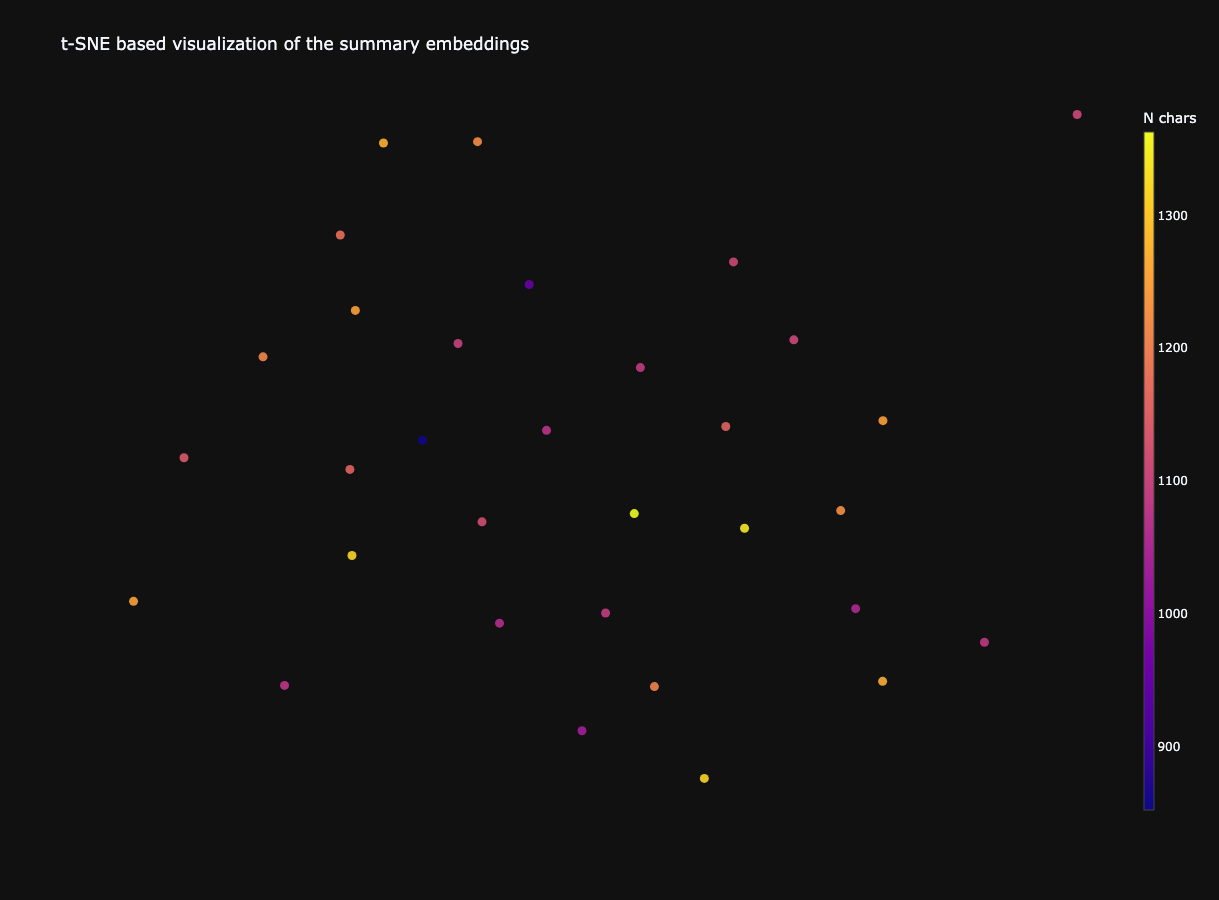

In [81]:
# Get embeddings as matrix from the dataframe
matrix = df.embedding.apply(eval).to_list()

# Use T-distributed Stochastic Neighbor Embedding to create joint probabilities.
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(np.array(matrix))

x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

fig = go.Figure()

# Scatter plot for UMAP in 2D
scatter_2d = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    # Color w.r.t. summary length
    marker = dict(color =[len(sm) for sm in df.summary],
                                          size=9, 
                                          opacity=0.9,
                                          colorbar=dict(thickness=10,x=1.1, title="N chars")),
    customdata= [sm.split('\n')[0] for sm in df.summary],
    hovertemplate='%{customdata}',
    visible = True,
    name=''
)
fig.add_trace(scatter_2d)

fig.update_layout(yaxis={'visible': False, 'showticklabels': False})
fig.update_layout(xaxis={'visible': False, 'showticklabels': False})

# Update layout
fig.update_layout(title = 't-SNE based visualization of the summary embeddings',
                 height = 900,
                 width = 936,
                 template = 'plotly_dark',
                 hovermode='closest',
                 showlegend = True)


plot(fig, filename = 'gptembed.html')
display(HTML('gptembed.html'))